## Intro

In [1]:
import numpy as np
import pandas as pd
import openpyxl as xl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb 
import shap
from featurewiz import FeatureWiz

shap.initjs()

2024-10-13 19:15:50.592874: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Imported lazytransform v1.16. 

Imported featurewiz 0.5.7. Use the following syntax:
    >>> wiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True,
        		category_encoders="auto", auto_encoders='VAE', ae_options={},
        		add_missing=False, imbalanced=False, verbose=0)
    >>> X_train_selected, y_train = wiz.fit_transform(X_train, y_train)
    >>> X_test_selected = wiz.transform(X_test)
    >>> selected_features = wiz.features
    


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('../../static/mock/ml-100(FE)_data/data2.csv', delimiter=';')
artifacts_path = '../../static/mock/ml-100(FE)_data/'
label_encoder = LabelEncoder()
data['Phase composition'] = label_encoder.fit_transform(data['Phase composition'])

print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Precursor          10 non-null     int64  
 1   Solvent            10 non-null     int64  
 2   t, C               10 non-null     int64  
 3   t, h               10 non-null     int64  
 4   pH                 10 non-null     float64
 5   HNO3               10 non-null     int64  
 6   CH3COOH            10 non-null     int64  
 7   HCl                10 non-null     int64  
 8   H2SO4              10 non-null     int64  
 9   t1, C              10 non-null     float64
 10  H1, J/g            10 non-null     float64
 11  t2, C              10 non-null     float64
 12  H2, J/g            10 non-null     float64
 13  Phase composition  10 non-null     int64  
 14  a(842), A          8 non-null      float64
 15  D(842), nm         8 non-null      float64
 16  SBET, m2/g         9 non-null

## Utils

In [3]:
def learn_xgboost(X, y, is_show_params=True):
    parameters = {
        'min_child_weight': [1, 5, 7, 10, 11, 12, 15,],
        'gamma': [0.5, 1, 1.5, 2, 2.5, 3, 5],
        'subsample': [0.4, 0.5, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
    }

    model = xgb.XGBRegressor(learning_rate=0.02, n_estimators=300, nthread=1, seed=0)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'explained_variance', 'neg_mean_absolute_percentage_error'],
        refit='neg_mean_squared_error',
        n_jobs=-1)
    clf.fit(X, y)
    best_model = clf.best_estimator_
    scores = {}
    if is_show_params:
        print(clf.best_params_)
    print("MSE: ", -clf.cv_results_['mean_test_neg_mean_squared_error'].max())
    scores['MSE'] = -clf.cv_results_['mean_test_neg_mean_squared_error'].max()
    print("EVS: ", clf.cv_results_['mean_test_explained_variance'].max())
    scores['EVS'] = clf.cv_results_['mean_test_explained_variance'].max()
    scores['MAPE'] = clf.cv_results_
    return best_model, scores

In [4]:
def explain(model, X, name="model", is_save=False, color_bar=False):
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    shap.plots.beeswarm(shap_values, max_display=20, plot_size=[10, 6], show=False, color_bar=color_bar)
    if is_save:
        plt.savefig(f'{artifacts_path}{name}_shap.png', bbox_inches='tight')
    plt.show()

## **Фазовый состав**

---

1.   Логистическая регрессия сработала, метрики +- хорошие
2.   Получилось сделать важность признаков по классам фазового состава


featurewiz is given 0.8 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['onehot', 'label']
    final list of scalers given: [std]
Loaded input data. Shape = (10, 31)
    selecting 31 numeric features for further processing...
#### Starting featurewiz transform for train data ####
    Single_Label Multi_Classification problem 
Shape of dataset: (10, 31). Now we classify variables into different types...
    Returning dictionary for variable types with following keys:
                        continuous_vars = 23, int_vars = 8, 
                        discrete_string_vars = 0, nlp_vars = 0,
                        date_vars = 0, time_deltas = 0,
                        categorical_vars = 0, date_zones = 0
    no date time variables detected in this dataset
    Beware! onehot encoding can create hundreds if not 1000s of variables...
label encoder selected for transforming all categorical variables
Using On

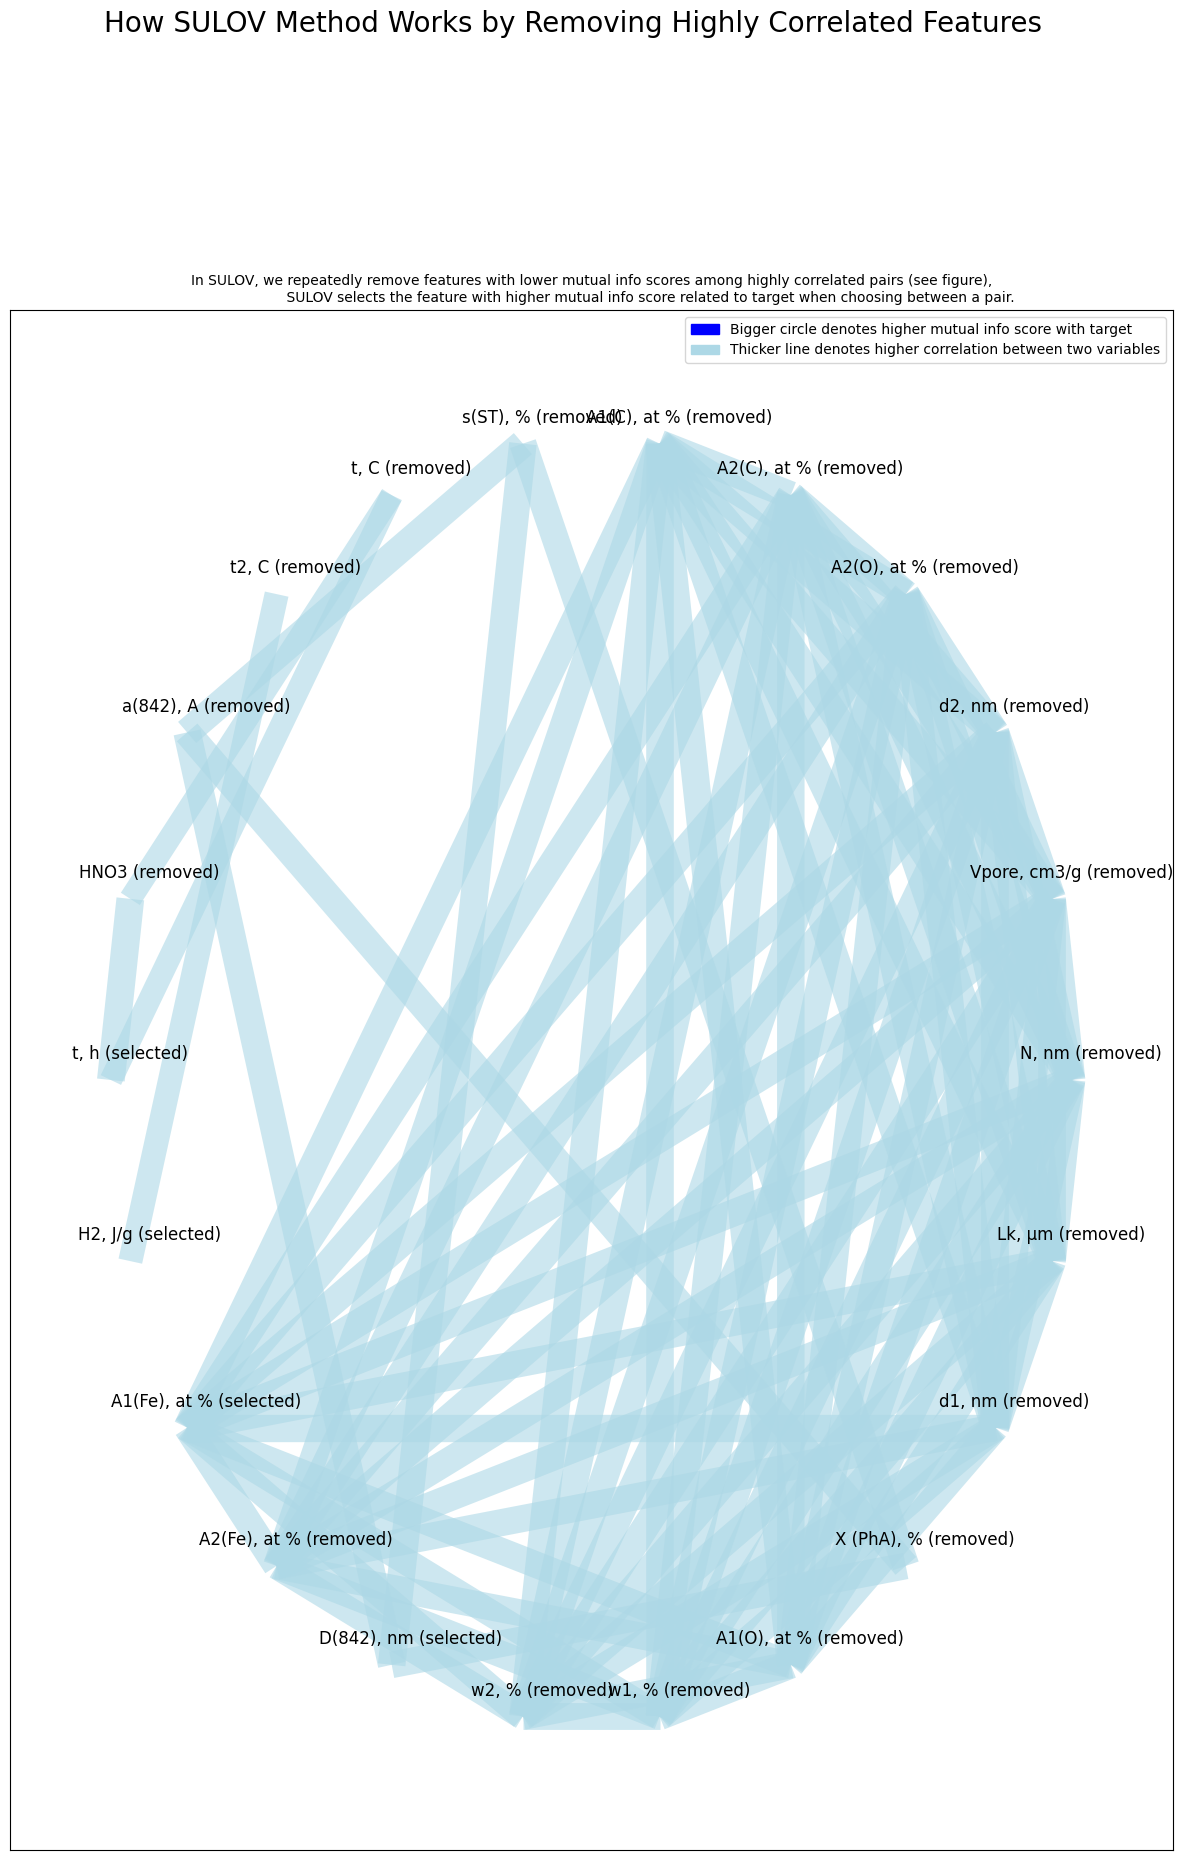

Performing recursive XGBoost feature selection from 13 features...
    Taking top 3 features per iteration...
    Number of booster rounds = 100
        Selected: ['t1, C', 'pH', 'A1(Fe), at %']
            Time taken for regular XGBoost feature selection = 0 seconds
        Selected: ['t1, C', 'pH', 'A1(Fe), at %']
            Time taken for regular XGBoost feature selection = 0 seconds
        Selected: ['t1, C', 'H2, J/g', 'A1(Fe), at %']
            Time taken for regular XGBoost feature selection = 0 seconds
        Selected: ['D(842), nm', 'H2, J/g', 'A1(Fe), at %']
            Time taken for regular XGBoost feature selection = 0 seconds


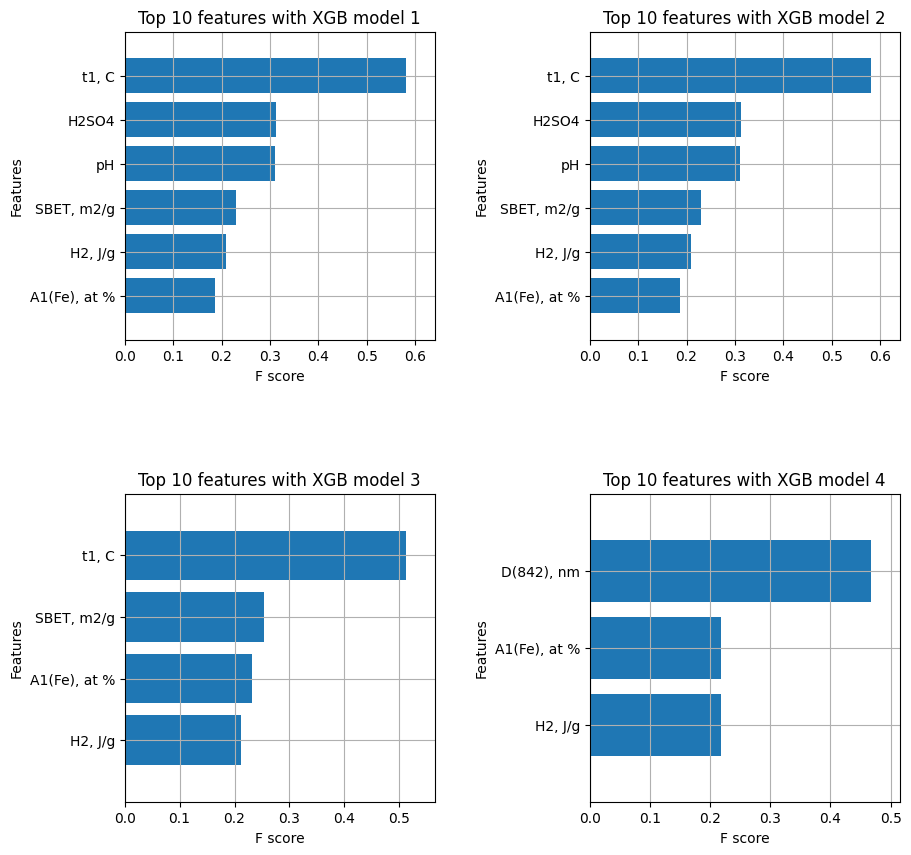

    time taken to run entire featurewiz = 1 second(s)
Recursive XGBoost selected 5 features...


['t1, C', 'pH', 'A1(Fe), at %', 'H2, J/g', 'D(842), nm']

In [5]:

fwiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True, scalers="std",
        		category_encoders="auto", add_missing=False, verbose=2, imbalanced=False, 
                ae_options={}, corr_limit=0.8)


X = data.drop('Phase composition', axis=1)
y = data['Phase composition']

X_pr, y_pr = fwiz.fit_transform(X, y)
fwiz.features  

## ОКР

---


1. Decision tree - неплохие метрики (удалила столбцы с сильной корреляцией, обучающая способность модели 53%)

Важен t1

featurewiz is given 0.8 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['onehot', 'label']
    final list of scalers given: [std]
Loaded input data. Shape = (8, 31)
    selecting 31 numeric features for further processing...
#### Starting featurewiz transform for train data ####
    Single_Label Multi_Classification problem 
Shape of dataset: (8, 31). Now we classify variables into different types...
    Returning dictionary for variable types with following keys:
                        continuous_vars = 22, int_vars = 9, 
                        discrete_string_vars = 0, nlp_vars = 0,
                        date_vars = 0, time_deltas = 0,
                        categorical_vars = 0, date_zones = 0
    no date time variables detected in this dataset
    Beware! onehot encoding can create hundreds if not 1000s of variables...
label encoder selected for transforming all categorical variables
Using OneH

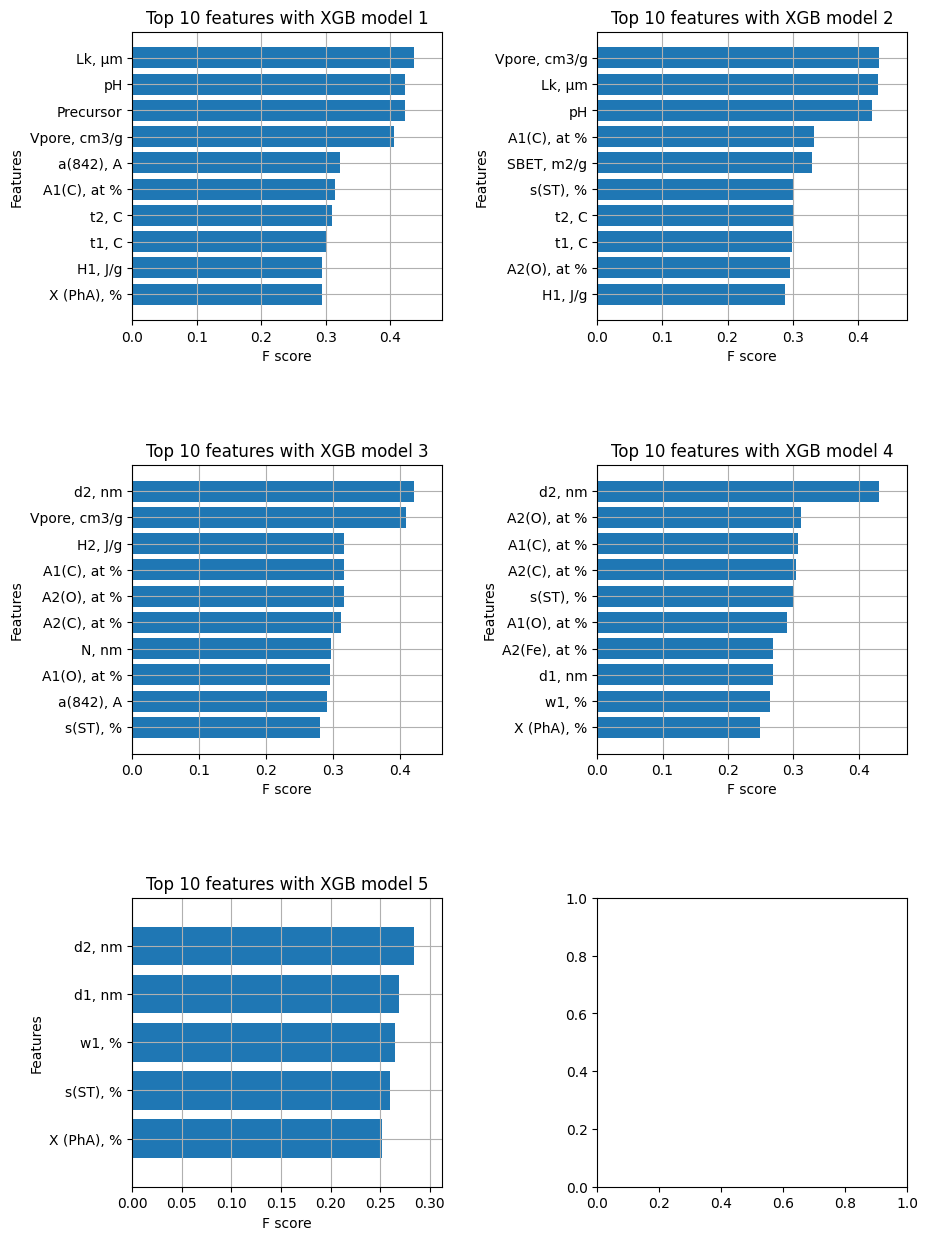

    time taken to run entire featurewiz = 2 second(s)
Recursive XGBoost selected 17 features...


['t1, C',
 'H1, J/g',
 'a(842), A',
 'N, nm',
 'A1(C), at %',
 'A2(C), at %',
 'A1(O), at %',
 'pH',
 't2, C',
 'SBET, m2/g',
 'H2, J/g',
 'A2(O), at %',
 'w1, %',
 'd1, nm',
 'X (PhA), %',
 'd2, nm',
 's(ST), %']

In [5]:
fwiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True, scalers="std",
        		category_encoders="auto", add_missing=False, verbose=2, imbalanced=False, 
                ae_options={}, corr_limit=0.8)
data_okr = data.dropna(subset="D(842), nm")
X = data_okr.drop('D(842), nm', axis=1)
y = data_okr['D(842), nm']
X_pr, y_pr = fwiz.fit_transform(X, y)
fwiz.features  

In [6]:
model, scores = learn_xgboost(X_pr, y_pr)

{'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.5}
MSE:  4.353481896136254
EVS:  0.6281732632036888


In [7]:
buf = None
for i in range(5):
    if i == 2:
        continue
    if buf is None:
        buf = scores["MAPE"][f'split{i}_test_neg_mean_absolute_percentage_error']
    else:
        buf += scores["MAPE"][f'split{i}_test_neg_mean_absolute_percentage_error']
(buf / 4).max()

-0.24552198364621117

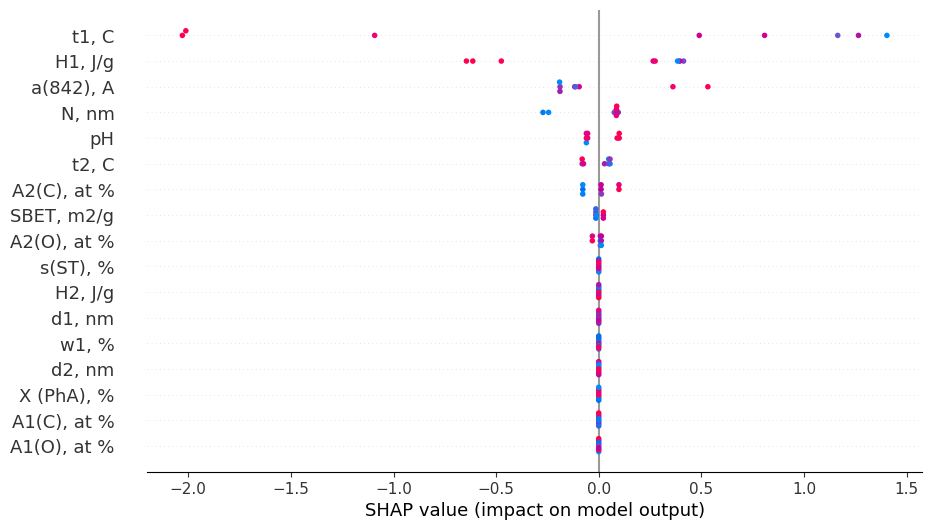

In [8]:
explain(model, X_pr, 'OKR', True)

## **МУРР**

---


1. Decision tree - хорошие метрики, убрала сильно коррелирующие столбцы

Важен t2

featurewiz is given 0.8 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['onehot', 'label']
    final list of scalers given: [std]
Loaded input data. Shape = (9, 31)
    selecting 31 numeric features for further processing...
#### Starting featurewiz transform for train data ####
    Single_Label Multi_Classification problem 
Shape of dataset: (9, 31). Now we classify variables into different types...
    Returning dictionary for variable types with following keys:
                        continuous_vars = 22, int_vars = 9, 
                        discrete_string_vars = 0, nlp_vars = 0,
                        date_vars = 0, time_deltas = 0,
                        categorical_vars = 0, date_zones = 0
    no date time variables detected in this dataset
    Beware! onehot encoding can create hundreds if not 1000s of variables...
label encoder selected for transforming all categorical variables
Using OneH

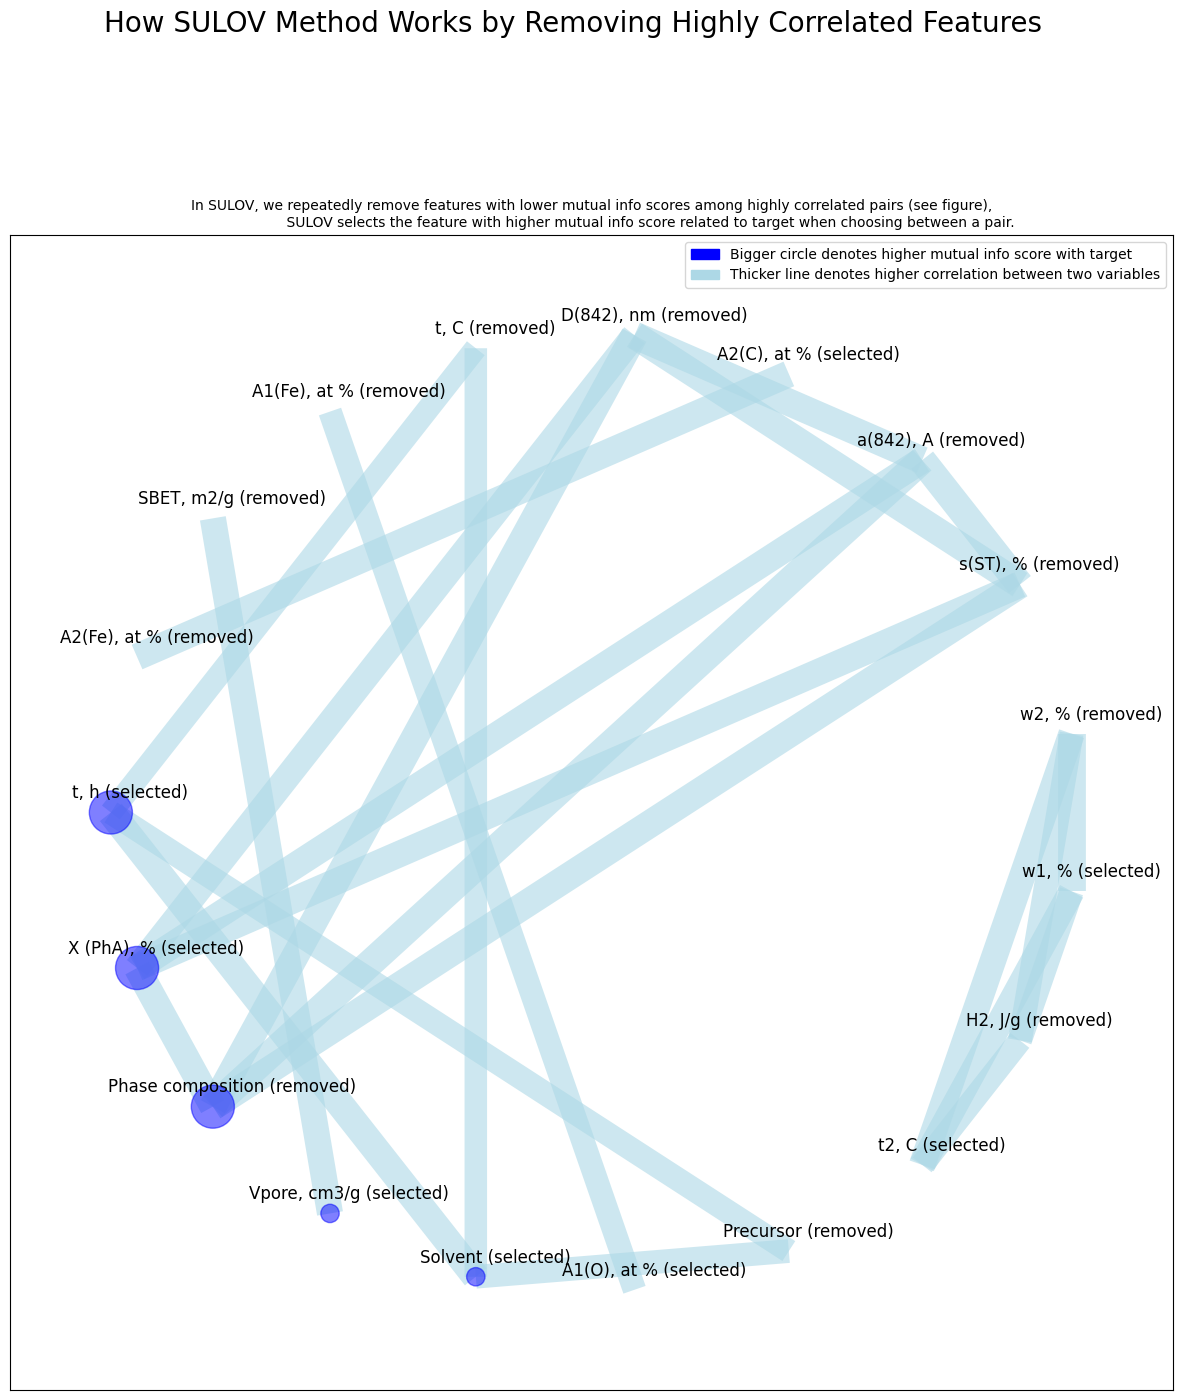

Performing recursive XGBoost feature selection from 20 features...
    Taking top 5 features per iteration...
    Number of booster rounds = 100
        Selected: ['N, nm', 'Lk, µm', 'd2, nm', 'X (PhA), %', 'A1(O), at %']
            Time taken for regular XGBoost feature selection = 0 seconds
        Selected: ['N, nm', 'Lk, µm', 'd2, nm', 'X (PhA), %', 'A1(O), at %']
            Time taken for regular XGBoost feature selection = 0 seconds
        Selected: ['A1(O), at %', 'Lk, µm', 'd2, nm', 'X (PhA), %', 'Vpore, cm3/g']
            Time taken for regular XGBoost feature selection = 0 seconds
        Selected: ['X (PhA), %', 'A1(O), at %', 'Vpore, cm3/g', 't2, C', 'A2(C), at %']
            Time taken for regular XGBoost feature selection = 0 seconds
        Selected: ['A1(O), at %', 't2, C', 'A2(C), at %', 'w1, %']
            Time taken for regular XGBoost feature selection = 0 seconds


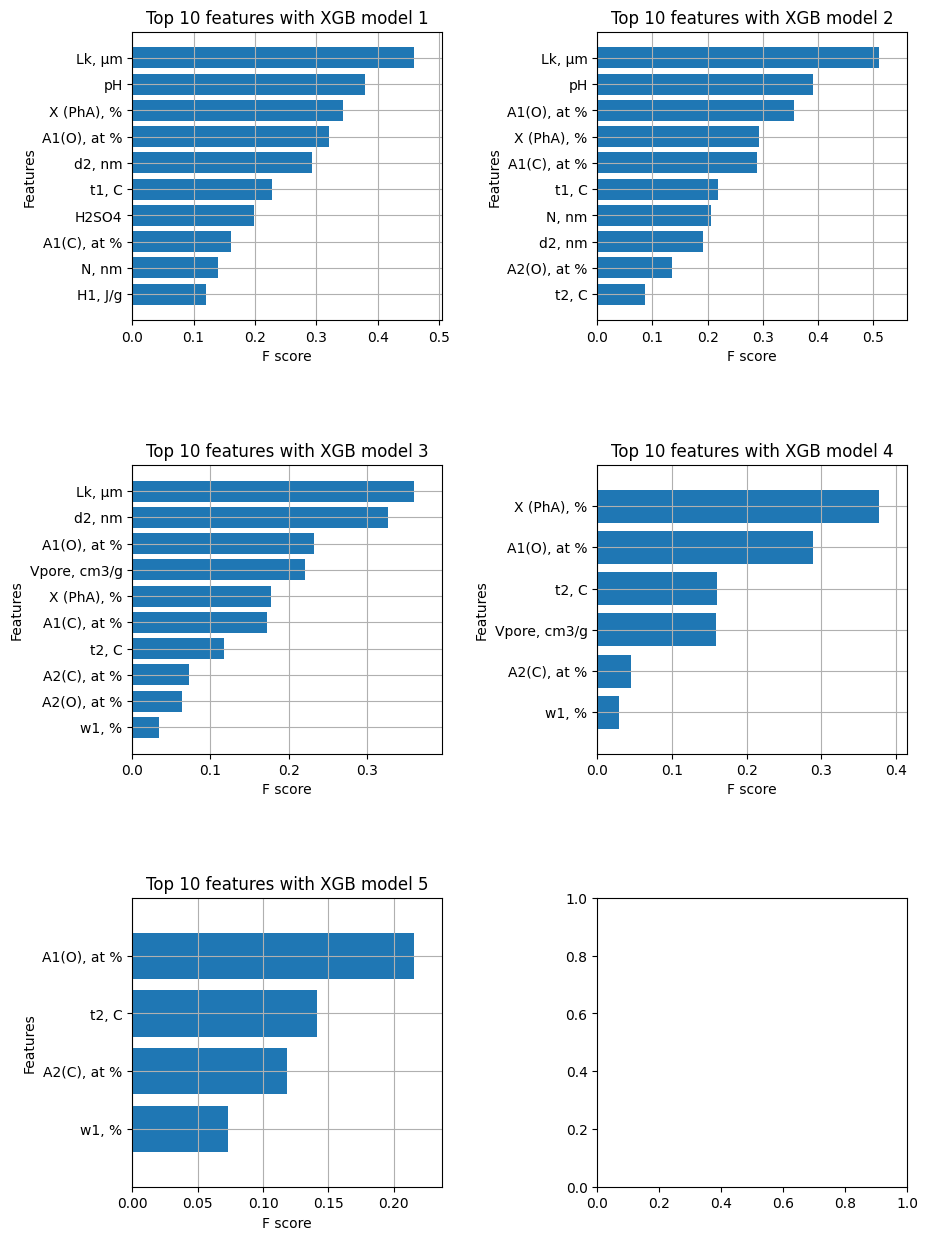

    time taken to run entire featurewiz = 3 second(s)
Recursive XGBoost selected 9 features...


['N, nm',
 'Lk, µm',
 'd2, nm',
 'X (PhA), %',
 'A1(O), at %',
 'Vpore, cm3/g',
 't2, C',
 'A2(C), at %',
 'w1, %']

In [5]:
fwiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True, scalers="std",
        		category_encoders="auto", add_missing=False, verbose=2, imbalanced=False, 
                ae_options={}, corr_limit=0.8)
data_murr = data.dropna(subset='d1, nm')
X = data_murr.drop('d1, nm', axis=1)
y = data_murr['d1, nm']
X_pr, y_pr = fwiz.fit_transform(X, y)
fwiz.features  

In [6]:
model, scores = learn_xgboost(X_pr, y_pr)

MAE:  2.5501270824494555
{'colsample_bytree': 0.5, 'gamma': 2, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}
MSE:  2.5501270824494555
EVS:  0.44638567928424083
MAPE:  -563215592875516.1


In [9]:
buf = None
for i in range(5):
    if i == 0:
        continue
    if buf is None:
        buf = scores["MAPE"][f'split{i}_test_neg_mean_absolute_percentage_error']
    else:
        buf += scores["MAPE"][f'split{i}_test_neg_mean_absolute_percentage_error']
(buf / 4).max()

-0.40764094293117525

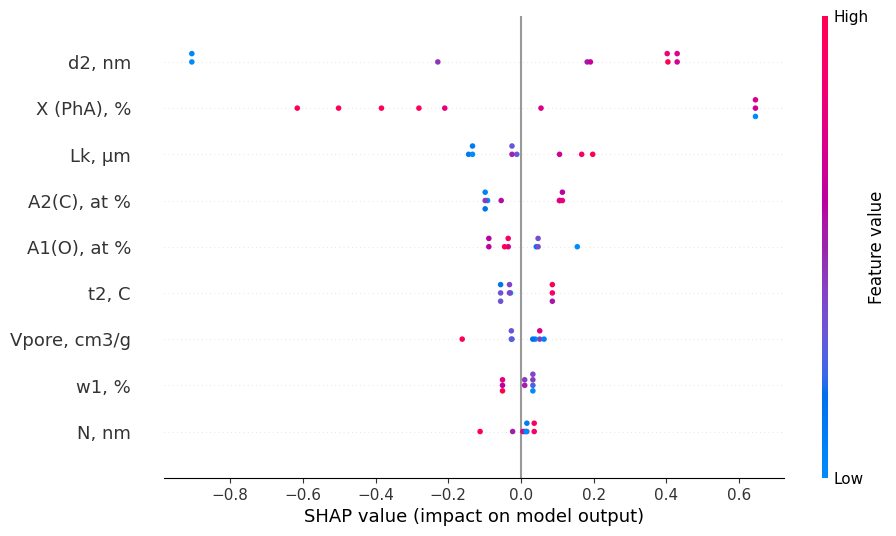

In [11]:
explain(model, X_pr, "MYPP", True, True)

## **Площадь поверхности**

---

1. XGBoost на 9 объектах (mae, mse большие, обучающая способность модели 47%)

Важны a(842), H1, A2(C)

featurewiz is given 0.8 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['onehot', 'label']
    final list of scalers given: [std]
Loaded input data. Shape = (9, 31)
    selecting 31 numeric features for further processing...
#### Starting featurewiz transform for train data ####
    Single_Label Multi_Classification problem 
Shape of dataset: (9, 31). Now we classify variables into different types...
    Returning dictionary for variable types with following keys:
                        continuous_vars = 22, int_vars = 9, 
                        discrete_string_vars = 0, nlp_vars = 0,
                        date_vars = 0, time_deltas = 0,
                        categorical_vars = 0, date_zones = 0
    no date time variables detected in this dataset
    Beware! onehot encoding can create hundreds if not 1000s of variables...
label encoder selected for transforming all categorical variables
Using OneH

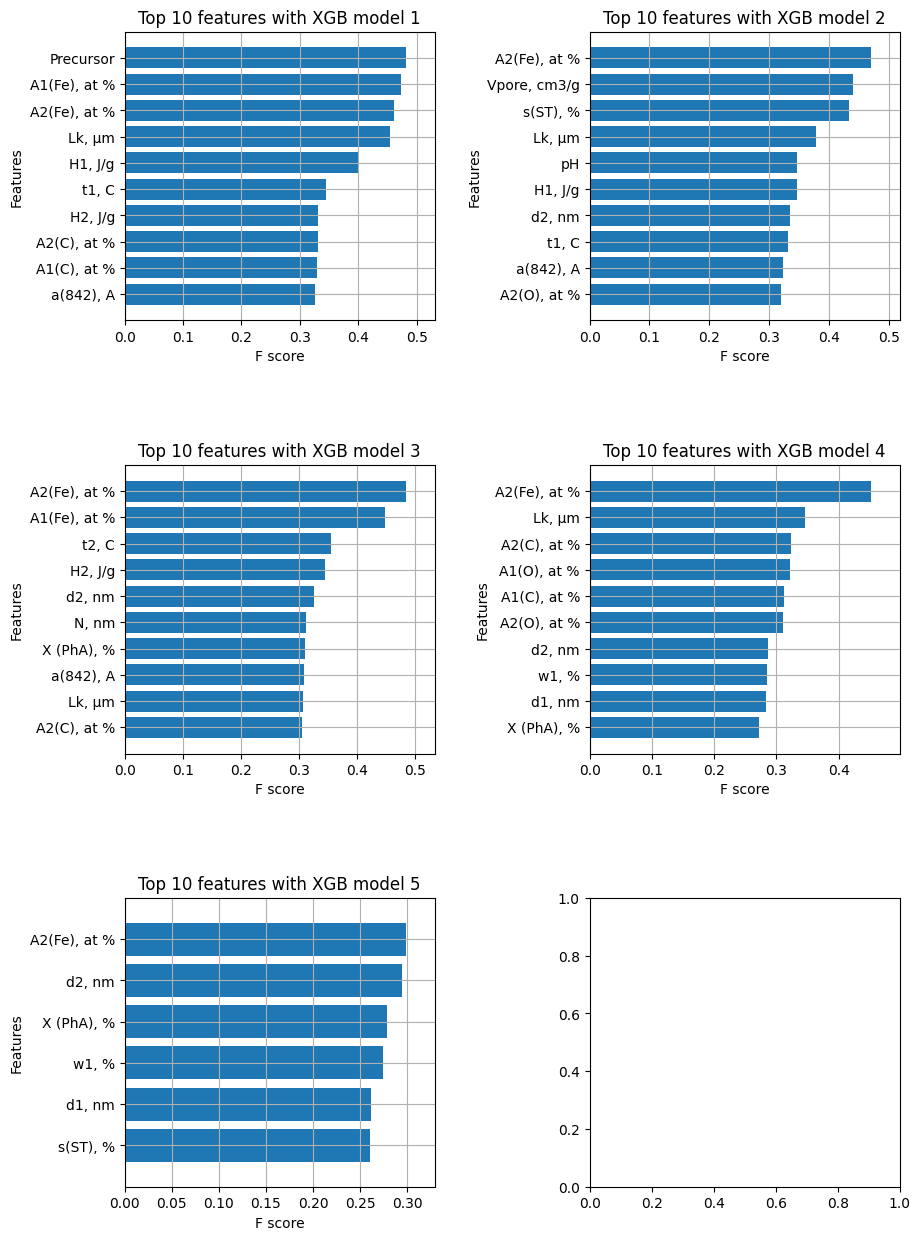

    time taken to run entire featurewiz = 3 second(s)
Recursive XGBoost selected 19 features...


['t1, C',
 'H1, J/g',
 't2, C',
 'H2, J/g',
 'a(842), A',
 'N, nm',
 'A1(C), at %',
 'A2(C), at %',
 'A1(O), at %',
 'A2(O), at %',
 'd1, nm',
 'd2, nm',
 'pH',
 'D(842), nm',
 'Lk, µm',
 'w1, %',
 'A2(Fe), at %',
 'X (PhA), %',
 's(ST), %']

In [5]:
fwiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True, scalers="std",
        		category_encoders="auto", add_missing=False, verbose=2, imbalanced=False, 
                ae_options={}, corr_limit=0.8)
data_s = data.dropna(subset='SBET, m2/g')
X = data_s.drop('SBET, m2/g', axis=1)
y = data_s['SBET, m2/g']
X_pr, y_pr = fwiz.fit_transform(X, y)
fwiz.features  

In [6]:
model, scores = learn_xgboost(X_pr, y_pr)

MAE:  5.305191781442886
{'colsample_bytree': 0.4, 'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8}
MSE:  5.305191781442886
EVS:  0.7623733880640288
MAPE:  -820785764594406.4


In [10]:
buf = None
for i in range(5):
    if i == 1:
        continue
    if buf is None:
        buf = scores["MAPE"][f'split{i}_test_neg_mean_absolute_percentage_error']
    else:
        buf += scores["MAPE"][f'split{i}_test_neg_mean_absolute_percentage_error']
(buf / 4).max()

-0.4067398040067582

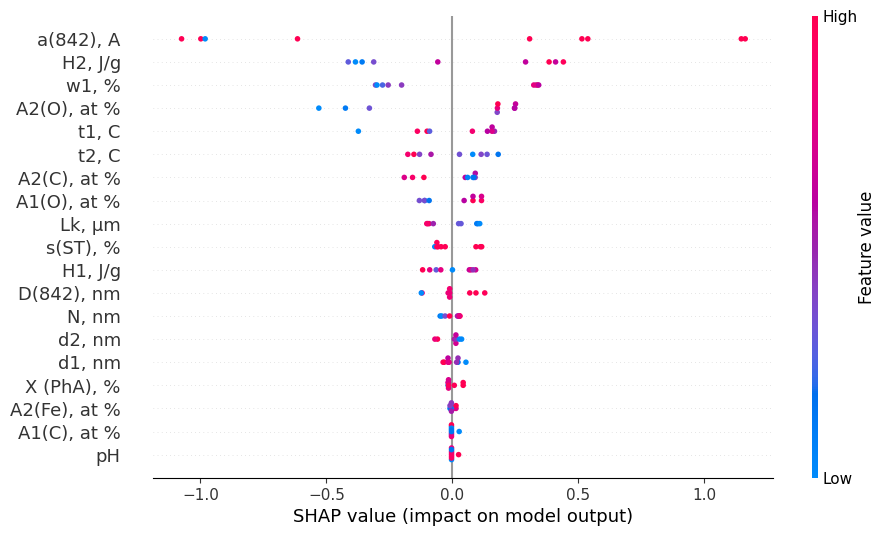

In [11]:
explain(model, X_pr, "S", True, True)

## **Объем пор**

---



1. XGBoost (обучающая способность 70%)

Важен a(842), H2, HCl, Прекурсор

featurewiz is given 0.8 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['onehot', 'label']
    final list of scalers given: [std]
Loaded input data. Shape = (9, 31)
    selecting 31 numeric features for further processing...
#### Starting featurewiz transform for train data ####
    Single_Label Multi_Classification problem 
Shape of dataset: (9, 31). Now we classify variables into different types...
    Returning dictionary for variable types with following keys:
                        continuous_vars = 22, int_vars = 9, 
                        discrete_string_vars = 0, nlp_vars = 0,
                        date_vars = 0, time_deltas = 0,
                        categorical_vars = 0, date_zones = 0
    no date time variables detected in this dataset
    Beware! onehot encoding can create hundreds if not 1000s of variables...
label encoder selected for transforming all categorical variables
Using OneH

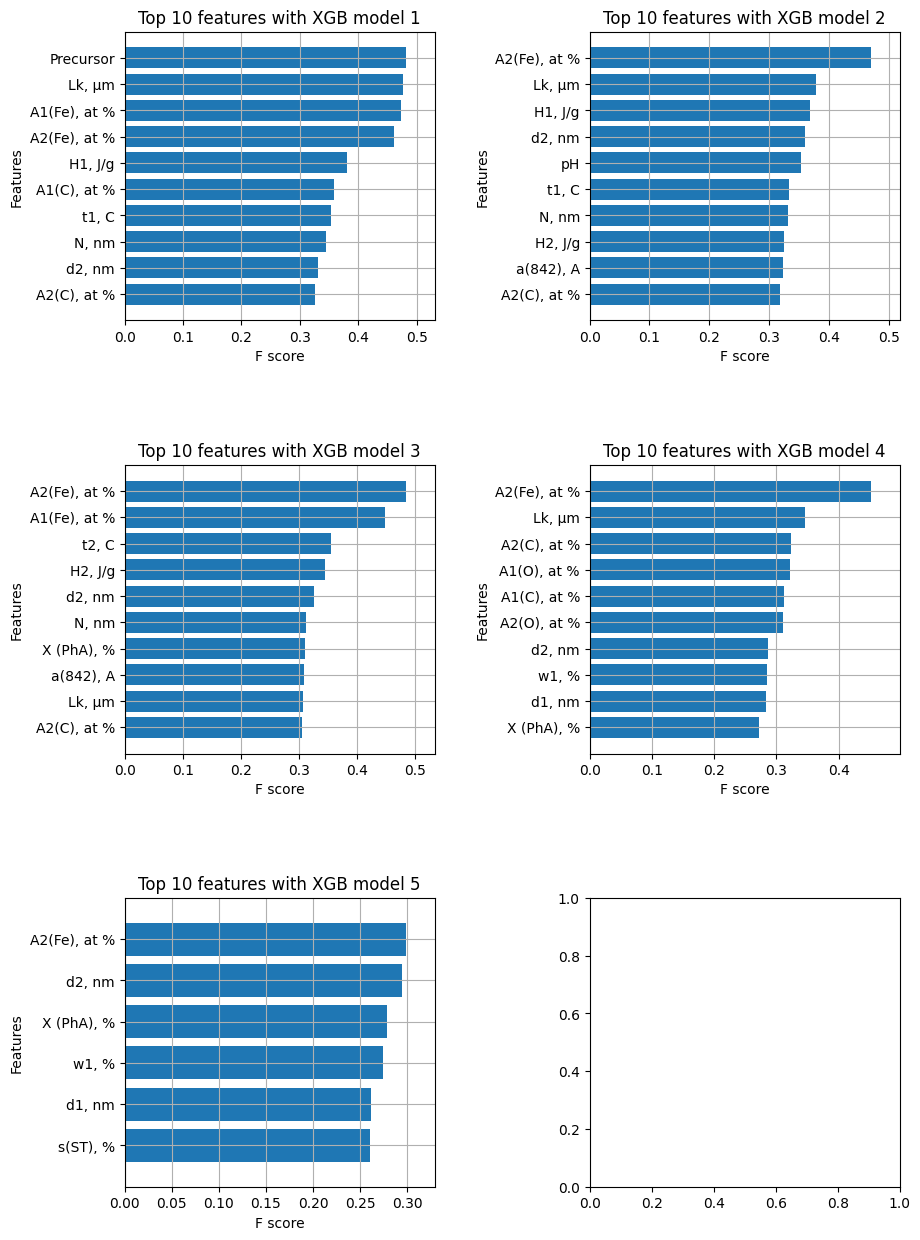

    time taken to run entire featurewiz = 2 second(s)
Recursive XGBoost selected 19 features...


['t1, C',
 'H1, J/g',
 't2, C',
 'H2, J/g',
 'a(842), A',
 'N, nm',
 'A1(C), at %',
 'A2(C), at %',
 'A1(O), at %',
 'A2(O), at %',
 'd1, nm',
 'd2, nm',
 'pH',
 'D(842), nm',
 'Lk, µm',
 'w1, %',
 'A2(Fe), at %',
 'X (PhA), %',
 's(ST), %']

In [5]:
fwiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True, scalers="std",
        		category_encoders="auto", add_missing=False, verbose=2, imbalanced=False, 
                ae_options={}, corr_limit=0.8)
data_v = data.dropna(subset='Vpore, cm3/g')
X = data_v.drop('Vpore, cm3/g', axis=1)
y = data_v['Vpore, cm3/g']
X_pr, y_pr = fwiz.fit_transform(X, y)
fwiz.features  

In [6]:
model, scores = learn_xgboost(X_pr, y_pr)

{'colsample_bytree': 0.4, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}
MSE:  7.1061970036553435
EVS:  0.5352411964733057


In [7]:
buf = None
for i in range(5):
    if i == 1:
        continue
    if buf is None:
        buf = scores["MAPE"][f'split{i}_test_neg_mean_absolute_percentage_error']
    else:
        buf += scores["MAPE"][f'split{i}_test_neg_mean_absolute_percentage_error']
(buf / 4).max()

-0.5272504933533214

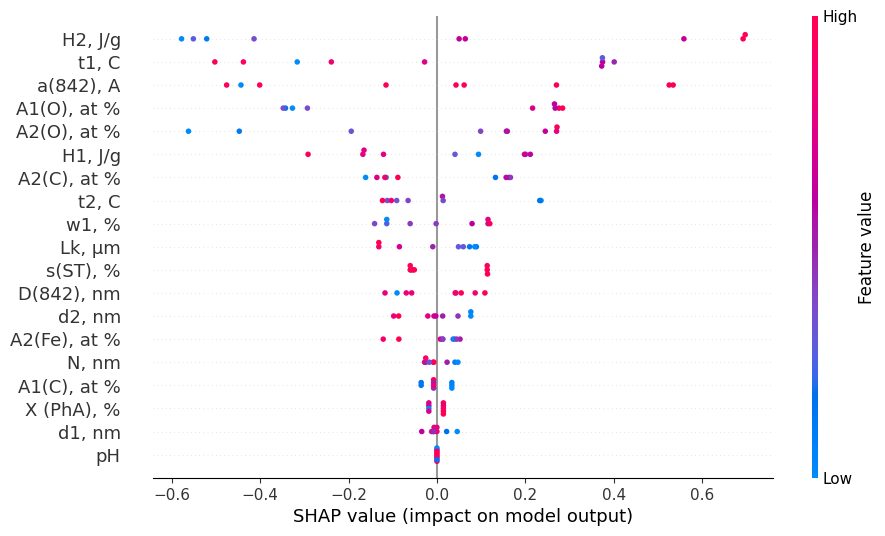

In [8]:
explain(model, X_pr, 'V', True, True)

## **Катализ**

---



1.   Перебрала все комбинации признаков, линейная регрессия обучается лучше всех, но все еще r2 < 0
2.   Деревья не дают веса, xgboost дает плохие метрики



featurewiz is given 0.8 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['onehot', 'label']
    final list of scalers given: [std]
Loaded input data. Shape = (8, 31)
    selecting 31 numeric features for further processing...
#### Starting featurewiz transform for train data ####
    Single_Label Multi_Classification problem 
Shape of dataset: (8, 31). Now we classify variables into different types...
    Returning dictionary for variable types with following keys:
                        continuous_vars = 22, int_vars = 9, 
                        discrete_string_vars = 0, nlp_vars = 0,
                        date_vars = 0, time_deltas = 0,
                        categorical_vars = 0, date_zones = 0
    no date time variables detected in this dataset
    Beware! onehot encoding can create hundreds if not 1000s of variables...
label encoder selected for transforming all categorical variables
Using OneH

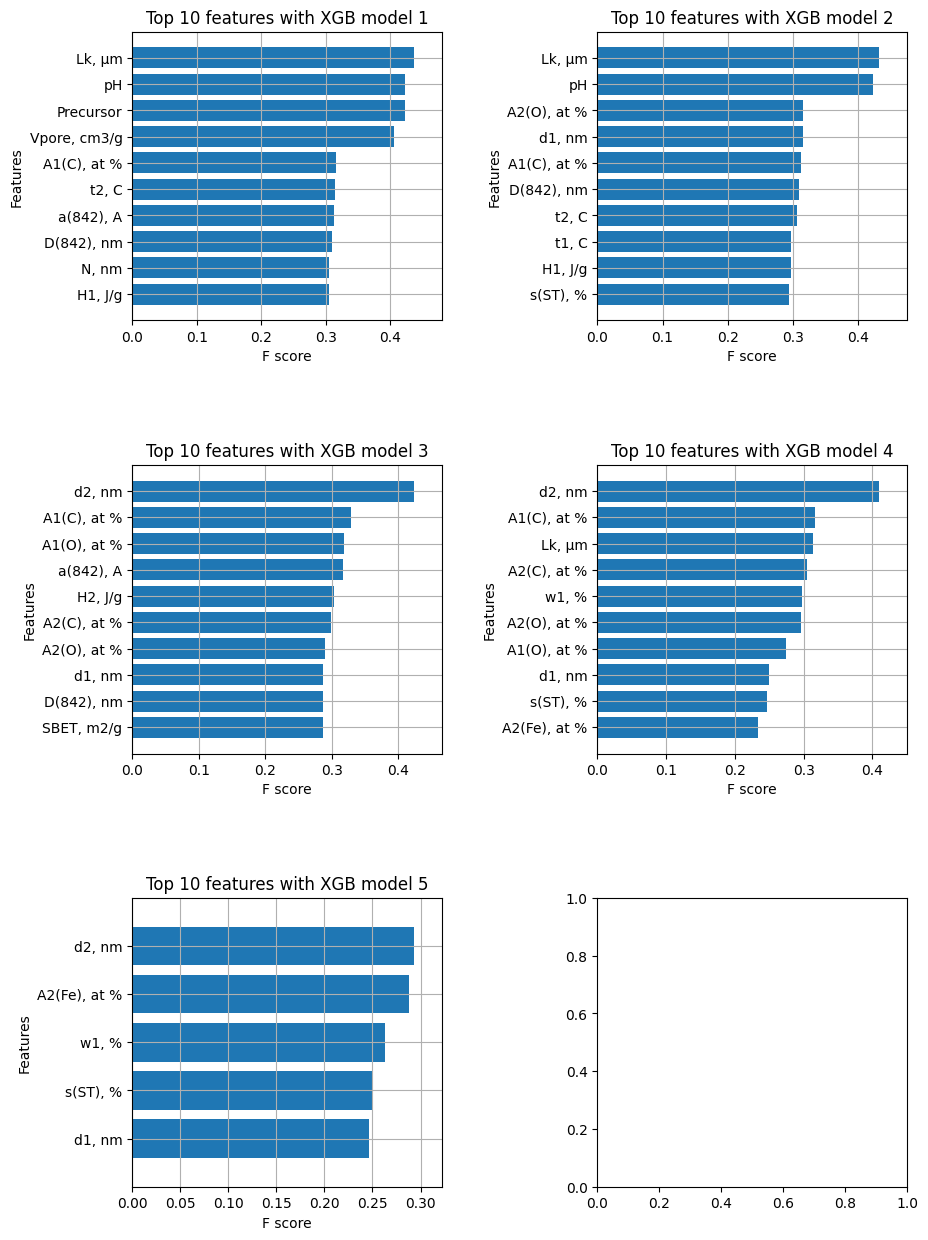

    time taken to run entire featurewiz = 2 second(s)
Recursive XGBoost selected 18 features...


['t1, C',
 'H1, J/g',
 'a(842), A',
 'N, nm',
 'A1(C), at %',
 'A2(C), at %',
 'A1(O), at %',
 't2, C',
 'SBET, m2/g',
 'H2, J/g',
 'D(842), nm',
 'A2(O), at %',
 'w1, %',
 'Lk, µm',
 'd1, nm',
 'A2(Fe), at %',
 'd2, nm',
 's(ST), %']

In [5]:
fwiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True, scalers="std",
        		category_encoders="auto", add_missing=False, verbose=2, imbalanced=False, 
                ae_options={}, corr_limit=0.8)
data_kat = data.dropna(subset='X (PhA), %')
X = data_kat.drop('X (PhA), %', axis=1)
y = data_kat['X (PhA), %']
X_pr, y_pr = fwiz.fit_transform(X, y)
fwiz.features  

In [6]:
model, scores = learn_xgboost(X_pr, y_pr)

{'colsample_bytree': 0.4, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8}
MSE:  5.942900177975059
EVS:  0.4060811463196387


In [10]:
buf = None
for i in range(5):
    if i == 0:
        continue
    if buf is None:
        buf = scores["MAPE"][f'split{i}_test_neg_mean_absolute_percentage_error']
    else:
        buf += scores["MAPE"][f'split{i}_test_neg_mean_absolute_percentage_error']
(buf / 4).max()

-0.8220328365763028

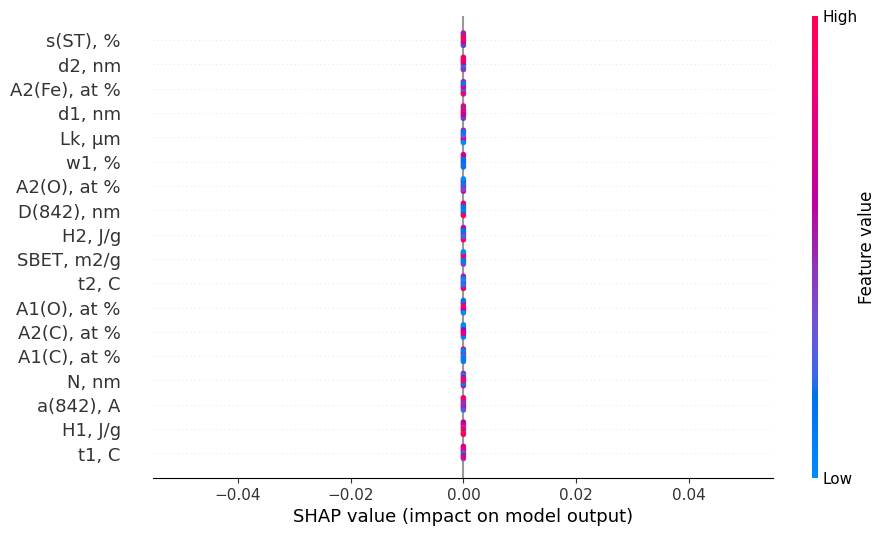

In [8]:
explain(model, X_pr, 'kat', True, True)

## Results
| Target              | MSE  | EVS  | MAPE |
|---------------------|------|------|------|
| OKP                 | 4.35 | 0.63 | 0.25 |
| MYPP                | 2.55 | 0.45 | 0.41 |
| Площадь поверхности | 5.31 | 0.76 | 0.41 |
| Объем пор           | 7.11 | 0.54 | 0.86 |
| Катализ             | 5.94 | 0.41 | 0.48 |